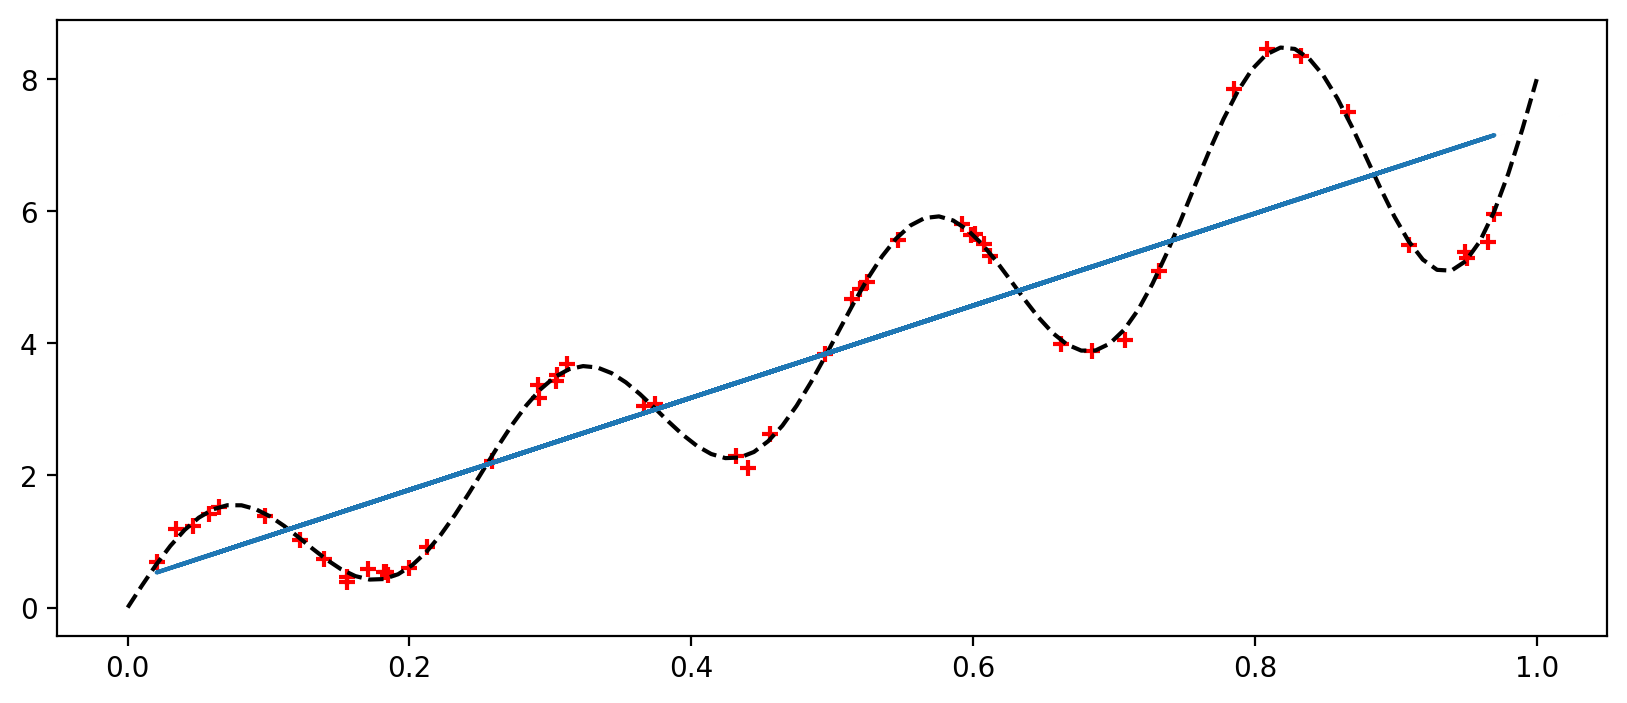

In [1]:
import sys
sys.path.append("..")   # add parent folder (project/) to Python path

from gplib.gp import *   # now absolute import works
import numpy as np 
import math 
import matplotlib.pyplot as plt 

np.random.seed(42)
N_points = 50
x = np.random.uniform(0,1,N_points).reshape(-1,1)
func = lambda x: np.exp(x**2)*np.sin(8*math.pi*x) + 8*x
y = ( func(x) + np.random.randn(x.shape[0], x.shape[1])*1e-1).ravel()
xtest = np.linspace(0,1,100).reshape(-1,1)
ytest = func(xtest)

plt.figure(figsize=(10,4), dpi=200)
plt.scatter(x,y, marker = '+', color = 'red')
plt.plot(xtest, ytest, linestyle = 'dashed', color = 'black', label = 'target')

Phi = jnp.hstack((jnp.ones((x.shape[0],1)), x))
beta = jnp.linalg.solve(Phi.T @ Phi + 1e-8 * jnp.eye(Phi.shape[1]), Phi.T @ y)
plt.plot(x, Phi @ beta, label = "Least squares approximation")

In [2]:
model = GP(x, y, RBF, Linear, kernel_params = jnp.ones(2), noise_var = 1e-9, epsilon = 1e-12, max_cond = 1e5, calibrate=True)
p = deepcopy(model.p)
print(neg_mll(model, p))
#optimizer = LBFGS(model, neg_mll, max_iter = 10000, tol = 1e-6, max_stepsize=1e-5, verbose = False)
optimizer = Momentum(model, neg_mll, beta = 0.9)
optimizer.kernel_latin_hypercube(15, min=-50, max = 50)

Calibrated white noise variance: 2.6054e-03
10674.119241325645
Best Objective Value: 3.3375e+01


In [3]:
optimizer.run(1e-4, 1000, ['k_param', 'm_param', 'noise_var'])

100%|██████████| 1000/1000 [00:11<00:00, 87.50it/s, Loss: 2.0470e+00]


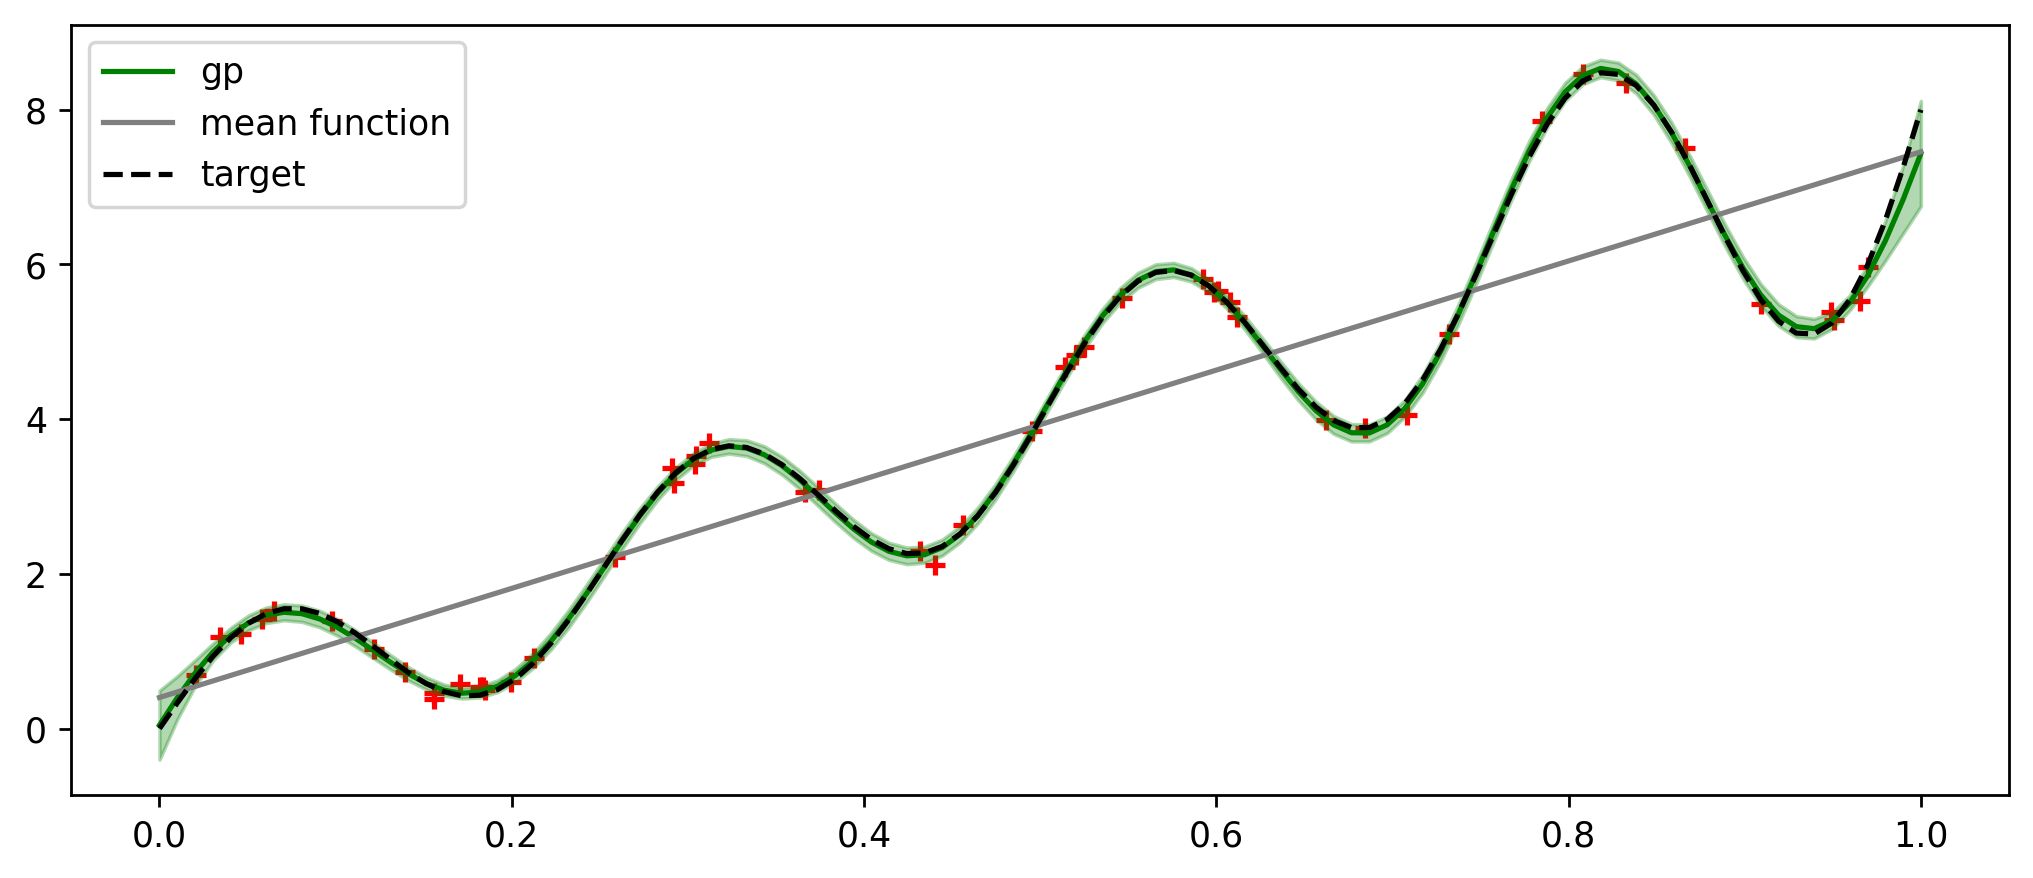

In [4]:
mu, cov = model.predict(xtest, full_cov = False)

plt.figure(figsize=(10,4), dpi = 250)
plt.scatter(x,y, marker = '+', color = 'red')
plt.plot(xtest, mu, color = 'green', label = 'gp')
plt.plot(xtest, model.mean.eval(xtest, model.p['m_param']), color = 'gray', label = 'mean function')
plt.fill_between(xtest.ravel(), mu -2*np.sqrt(cov), mu + 2*np.sqrt(cov), alpha = 0.3, color = 'green')
plt.plot(xtest, ytest, linestyle = 'dashed', color = 'black', label = 'target')
plt.legend()